In [1]:
import pandas as pd
import numpy as np
import atmos
import units
import matplotlib.pyplot as plt
import plotly.offline as pyo
import plotly.graph_objs as go 

pyo.init_notebook_mode(connected=True)

# Features to add:
1. Optimization of an arbitrary feature:
 * Create a function that will iterate through design parameters until an optimal solution is found based on an input of parameter, high or low optimization, and keyword args for other parameters.

In [8]:
def lbf2N(value):
    return value*4.44822

def N2lbf(value):
    return value/4.44822

In [18]:
duration = 10000  # [s]
timestep = 0.1  # [s]

gas_constant = 287  # [J/kg/K] gas constant for air
gamma = 1.2

# constants
g0 = 9.81  # [m/s/s]
Re = 6378000  # [m]

averageTWRatio = 80

# engine definition
Isp = 300  # [s]
nengines = 5
thrust_sl = nengines*24000  # [N]
Ae = 0.25  # [m^2]
pe = units.Value(101325.0,'Pa')  # [atm]
mdot = thrust_sl/(g0*Isp)  # [kg/s]
mpropulsion = thrust_sl/averageTWRatio/g0 # [1]
mstructure = 200  # [kg]
mpayload = 0  # [kg]
burntime = [60, 0]  # [s] three burns, launch, reentry, landing
totalburn = sum(burntime)
mprop = mdot*totalburn  # [kg]
m0 = mstructure + mpayload + mprop + mpropulsion
mf = m0 - mprop # [kg]
massratio = mprop/m0
print('mass ratio =', massratio)
print('dry mass = ', mf)
print('wet mass = ', m0)
print('propellant mass =', mprop)
print('propulsion system mass =', mpropulsion)
print('Thrust: %i N' % thrust_sl)
print('Thrust: %i lbf' % N2lbf(thrust_sl))

initialThrust2Weight = thrust_sl/(m0*g0)
print('initialThrust2Weight =', initialThrust2Weight)

atm = atmos.SimpleAtmos()

# vehicle stuff
S = 10  # [m^2] surface area
max_accel = 1*g0  # maximum acceleration (2g)

mass ratio = 0.8739348918505572
dry mass =  352.9051987767584
wet mass =  2799.388379204893
propellant mass = 2446.483180428135
propulsion system mass = 152.9051987767584
Thrust: 120000 N
Thrust: 26977 lbf
initialThrust2Weight = 4.369674459252785


In [3]:
def calc_thrust(thrust_sl, Ae, pe, pa):
    return thrust_sl + (pe-pa)*Ae

def calc_dV():
    thrust*np.cos(epsilon)
    
def calc_drag(U,gamma,R,T,rho,Cd,sos):
    if T == 0:
        return 0
    M = U/sos
    return 1/2*rho*U**2*S*Cd

In [4]:
# standard atmosphere model (SI units)
def STDATM(altitude):
    R_air = 287             # gas constant [J/kg/K]
    gamma_air = 1.4         # ratio of specific heats
    g0 = 9.8                # gravity constant [m/s]
     
    layer = -1.0            # gradient layer
    gradient = -0.0065
    altitude_base = 0.0
    temperature_base = 288.16
    density_base = 1.2250
    
    if altitude > 11000.0:
        layer = 1.0       # isothermal layer
        altitude_base = 11000.0
        temperature_base = 216.66
        density_base = 0.3648 
    elif altitude > 25000.0:
        layer = -1.0      # gradient layer
        gradient = 0.003
        altitude_base = 25000.0
        temperature_base = 216.66
        density_base = 0.04064
    elif altitude > 47000.0:
        layer = 1.0       # isothermal layer
        altitude_base = 47000.0
        temperature_base = 282.66
        density_base = 0.001476
    elif altitude > 53000.0:
        layer = -1.0      # gradient layer
        gradient = -0.0045
        altitude_base = 53000.0
        temperature_base = 282.66
        density_base = 0.0007579
    elif altitude > 79000.0:
        layer = 1.0       # isothermal layer
        altitude_base = 79000.0
        temperature_base = 165.66
        density_base = 0.0000224    
    elif altitude > 90000.0:
        layer = -1.0      # gradient layer
        gradient = 0.004
        altitude_base = 90000.0
        temperature_base = 165.66
        density_base = 0.00000232
    if layer < 0.0:
        temperature = temperature_base + gradient*(altitude - altitude_base)
        power = -1.0*(g0/gradient/R_air + 1.0)
        density = density_base*(temperature/temperature_base)**power
    else:
        temperature = temperature_base
        power = -1.0*g0*(altitude - altitude_base)/R_air/temperature
        density = density_base*np.exp(power)
    sos = np.sqrt(gamma_air*R_air*temperature)
    
    return (temperature, density, sos)

In [41]:
mass = [m0]
velocity = [0]
thrust = [thrust_sl]
altitude = [0]
R = []
thrust_angle = 0
drag = [0]
heading = np.deg2rad(90)
dynamicPressure = [0]
heatInput = [0]
machNumber = [0]

accel = [0]
gravityterm = [g0]

timearray = [0]

i = 0  # iterator
for time in np.linspace(0,duration,num=duration/timestep+1):
    R.append(Re+altitude[i])
    
    altitude.append(altitude[i]+velocity[i]*np.sin(heading)*timestep)
    dVdt = ((thrust[i]*np.cos(thrust_angle)-drag[i])/mass[i] - g0*(Re/R[i])**2*np.sin(heading))
    velocity.append(velocity[i]+dVdt*timestep)
    accel.append(dVdt)
    
    gravityterm.append((-g0*(Re/R[i])**2*np.sin(heading))*timestep)
    
    T, rho, sos = STDATM(altitude[i])  # Thermoproperties
    
    M = velocity[i]/sos
    machNumber.append(abs(M))
    Cd = 0.15 + 0.6*M**2*np.exp(-M**2)
    drag.append(calc_drag(velocity[i], gamma, gas_constant, T, rho, Cd, sos))

    dynamicPressure.append(1/2*rho*velocity[i]**2)
    
    heatInput.append(1/2*dynamicPressure[i]*abs(velocity[i])*S*Cd/3)
    
    timearray.append(time)
    
    if altitude[i]<0 and time>burntime[0]:
        pa = atm.pressure(0,'m')
        thrust.append(0)
        mass.append(mass[i])
        break
    else:
        pa = atm.pressure(altitude[i],'m')
    if time < burntime[0]:
        """ Launch burn """
        thrust.append(calc_thrust(thrust_sl,Ae,pe.SIValue,pa.SIValue))
        mass.append(mass[i]-mdot*timestep)
    else:
        thrust.append(0)
        mass.append(mass[i])   
    i += 1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning:

object of type <class 'float'> cannot be safely interpreted as an integer.



Apogee = 130 km


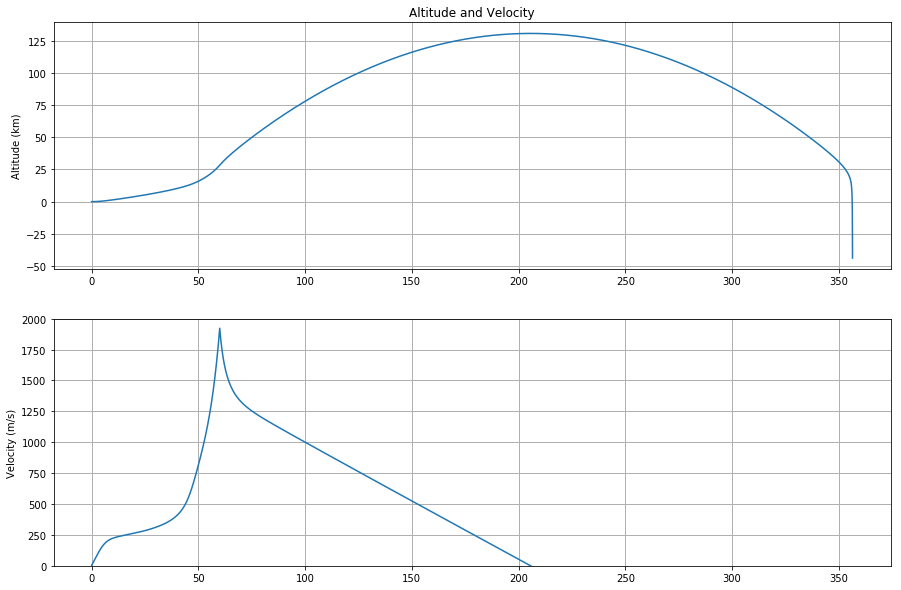

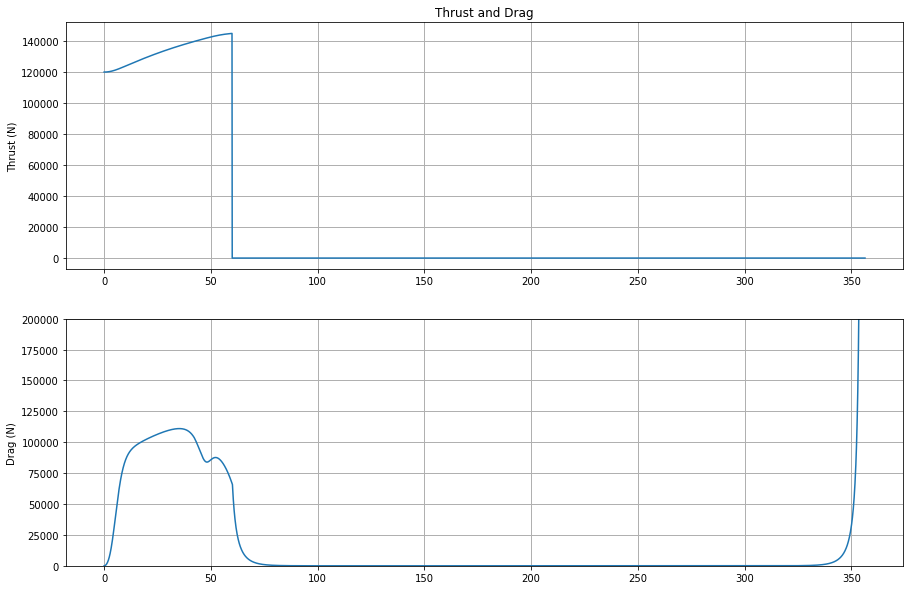

In [67]:
kmaltitude = [x/1000 for x in altitude]

print('Apogee = %d km' % max(kmaltitude))

fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.2)

fig2 = plt.figure(figsize=(15,10))
fig2.subplots_adjust(hspace=0.2)

plot_alt(fig)
plot_thrust(fig2)

plt.show()

In [66]:
def plot_alt(fig):
    # plot altitude
    ax1 = fig.add_subplot(2,1,1)
    ax1.xaxis.grid(linewidth=1.0)
    ax1.yaxis.grid(linewidth=1.0)
    ax1.grid(True, linewidth=1)
    ax1.plot(timearray,kmaltitude)
    ax1.set_ylabel('Altitude (km)')

    ax1.set_title('Altitude and Velocity')

    
    # plot velocity
    ax2 = fig.add_subplot(2,1,2)
    ax2.xaxis.grid(linewidth=1.0)
    ax2.yaxis.grid(linewidth=1.0)
    ax2.set_ylim(0,2000)
    ax2.grid(True, linewidth=1)
    ax2.plot(timearray,velocity)
    ax2.set_ylabel('Velocity (m/s)')

def plot_thrust(fig):
    # plot thrust
    ax = fig.add_subplot(2,1,1)
    ax.xaxis.grid(linewidth=1.0)
    ax.yaxis.grid(linewidth=1.0)
    ax.grid(True, linewidth=1)
    ax.plot(timearray,thrust)
    ax.set_ylabel('Thrust (N)')
    
    ax.set_title('Thrust and Drag')
    
    # plot drag
    ax1 = fig.add_subplot(2,1,2)
    ax1.xaxis.grid(linewidth=1.0)
    ax1.yaxis.grid(linewidth=1.0)
    ax1.grid(True, linewidth=1)
    ax1.plot(timearray,drag)
    ax1.set_ylabel('Drag (N)')
    ax1.set_ylim(0,2e5)

In [1]:
# Plot Altitude
# Create a trace
trace = go.Scatter(
    x = timearray,
    y = kmaltitude
)
data = [trace]
# Edit the layout
layout = dict(title = 'Altitude vs. Time',
    xaxis = dict(title = 'Time (s)'),
    yaxis = dict(title = 'Altitude (km)'))
fig = dict(data=data, layout=layout)
pyo.iplot(fig, filename='altitude-time_mae155a')

# Plot Thrust to Weight 
weight = [x*g0 for x in mass]
ratio = [thrust_sl/w for w in weight]
trace = go.Scatter(
    x = timearray,
    y = ratio
)
data = [trace]
layout = dict(title='Thrust to Weight Ratio',
              xaxis = dict(title='Time (s)'),
              yaxis = dict(title='Thrust/Weight'))
fig = dict(data=data, layout=layout)
pyo.iplot(fig,filename='thrust-to-weight_mae155a')

# Plot Thrust
kNthrust = [x/1000 for x in thrust]
trace = go.Scatter(
    x = timearray,
    y = kNthrust
)
data =[trace]
layout = dict(title = 'Thrust vs. Time',
              xaxis = dict(title = 'Time (s)'),
              yaxis = dict(title = 'Thrust (kN)'))
fig = dict(data=data, layout=layout)
pyo.iplot(fig,filename='thrust-time_mae155a')

# Plot Acceleration
gees = [(x+g0)/g0 for x in accel]
trace = go.Scatter(
    x = timearray,
    y = gees
)
data = [trace]
layout = dict(title = 'Acceleration vs. Time',
              xaxis = dict(title = 'Time (s)'),
              yaxis = dict(title = 'Acceleration (gee\'s)'))
fig = dict(data=data,layout=layout)
pyo.iplot(fig, filename='acceleration-time_mae155a')

# Plot Velocity
trace = go.Scatter(
    x = timearray,
    y = velocity)
data = [trace]

layout = dict(title = 'Velocity vs. Time',
              xaxis = dict(title='Time (s)'),
              yaxis = dict(title='Velocity (m/s)'))

fig = dict(data=data, layout=layout)
pyo.iplot(fig, filename='velocity-time_mae155a')

# Plot Mass
trace = go.Scatter(
    x = timearray,
    y = mass)
data = [trace]
layout = dict(title='Mass vs. Time',
              xaxis = dict(title='Time (s)'),
              yaxis = dict(title='Mass (kg)'))
fig = dict(data=data, layout=layout)
pyo.iplot(fig, filename='mass-time_mae155a')

NameError: name 'go' is not defined

In [437]:
# Plot Drag
kNdrag = [x/1000 for x in drag]
trace = go.Scatter(
    x = timearray,
    y = kNdrag
)
data = [trace]
layout = dict(title = 'Drag',
              xaxis = dict(title = 'Time (s)'),
              yaxis = dict(title = 'Drag (kN)'))
fig = dict(data=data, layout=layout)
pyo.iplot(fig)

trace = go.Scatter(
    x = timearray,
    y = dynamicPressure
)
data = [trace]
layout = dict(title = 'Dynamic Pressure',
              xaxis = dict(title = 'Time (s)'),
              yaxis = dict(title = 'Dynamic Pressure Pa'))
fig = dict(data=data, layout=layout)
pyo.iplot(fig)

trace = go.Scatter(
    x = timearray,
    y = machNumber
)
data = [trace]
layout = dict(title = 'Mach Number',
              xaxis = dict(title = 'Time (s)'),
              yaxis = dict(title = 'Mach Number'))
fig = dict(data=data, layout=layout)
pyo.iplot(fig)

trace = go.Scatter(
    x = timearray,
    y = heatInput
)
data = [trace]
layout = dict(title = 'Heat Input',
              xaxis = dict(title = 'Time (s)'),
              yaxis = dict(title = 'Heat Input (kJ)'))
fig = dict(data=data, layout=layout)
pyo.iplot(fig)